## Predict roof and country, all data

Using rotated to hz + OpenCv border

Basic default transforms

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import geopandas as gpd
from resizeimage import resizeimage
import datetime
import uuid
from os import listdir
from os.path import isfile, join
from ipyexperiments import *

In [3]:
torch.cuda.set_device(2)
torch.cuda.current_device()

2

In [4]:
data_dir = Path('data')
colombia_rural = Path('data/stac/colombia/borde_rural')
colombia_soacha = Path('data/stac/colombia/borde_soacha')

In [5]:
guatemala_mixco1 = Path('data/stac/guatemala/mixco_1_and_ebenezer')
guatemala_mixco3 = Path('data/stac/guatemala/mixco_3')

In [6]:
st_lucia_castries = Path('data/stac/st_lucia/castries')
st_lucia_dennery = Path('data/stac/st_lucia/dennery')
st_lucia_gros_islet = Path('data/stac/st_lucia/gros_islet')

In [7]:
COUNTRY='colombia'
REGION='borde_rural'
DATASET = f'{COUNTRY}_{REGION}'
DATASET_PATH=colombia_rural
path=data_dir/f'{COUNTRY}_{REGION}/cropped/'
TRAIN_JSON = f'train-{REGION}.geojson'
TEST_JSON = f'test-{REGION}.geojson'

In [8]:
RESIZE_IMAGES = True

In [9]:
MODEL_NAME='cv_reflect_101'

In [10]:
NB_NUM='09_7'

In [11]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}, DATE: {DATE}')                                                 

UID: 2a3cbd10, DATE: 20191123


In [12]:
DATE = '20191123'
UID = 'b4030283'

In [13]:
SUB_NUM='2'

In [14]:
img_size=256
bs=128

In [15]:
train_images=data_dir/f'train/rotated/clipped/{img_size}'
test_images=data_dir/f'test/rotated/clipped/{img_size}'

In [16]:
test_names = get_image_files(test_images)

In [17]:
assert len(test_names)==7325

In [18]:
df_all=pd.read_csv(data_dir/'df_train_all.csv')

In [19]:
df_all.tail()

,id,roof_material,verified,country,region
22548,7a22ddec,healthy_metal,False,st_lucia,gros_islet
22549,7a2f73ea,healthy_metal,False,st_lucia,gros_islet
22550,7a34ffa4,healthy_metal,False,st_lucia,gros_islet
22551,7a41560a,healthy_metal,False,st_lucia,gros_islet
22552,7a283ad0,healthy_metal,False,st_lucia,gros_islet


In [20]:
#### Sepate roof types per country

In [21]:
df_all['target']=df_all['roof_material']+'_'+df_all['country']

In [22]:
df_test=pd.read_csv(data_dir/'df_test_all.csv')

In [23]:
df_test.tail()

,id,country,region
7320,7a4f3ff4,st_lucia,dennery
7321,7a4fc578,st_lucia,dennery
7322,7a4ac7b2,st_lucia,dennery
7323,7a47e25e,st_lucia,dennery
7324,7a4e3f78,st_lucia,dennery


In [24]:
assert len(df_test)==7325

In [25]:
df_all.loc[df_all['id'] == '7a204ec4']

,id,roof_material,verified,country,region,target
12960,7a204ec4,irregular_metal,True,guatemala,mixco_1_and_ebenezer,irregular_metal_guatemala


In [26]:
len(df_all)

22553

To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [27]:
#xtra_tfms=[rand_crop(p=0.4)], 
#tfms = get_transforms(flip_vert=True, max_lighting=0.25, max_zoom=1.2, max_warp=0., xtra_tfms=xtra_tfms)

tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

### setup dataset

In [28]:
np.random.seed(42)
dep_var='target'
src = (ImageList.from_df(path=train_images, df=df_all, cols='id', suffix='.tif')
       .split_by_rand_pct(0.1)
      .label_from_df(cols=dep_var)
      .add_test_folder(test_images))

22553


In [29]:
data = (src.transform(tfms, size=img_size)
        .databunch(bs=bs).normalize(imagenet_stats))

In [30]:
#to check what params object has
#dir(data)

In [31]:
data.label_list

LabelLists;

Train: LabelList (20298 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement_colombia,irregular_metal_colombia,healthy_metal_colombia,healthy_metal_colombia,healthy_metal_colombia
Path: data/train/rotated/clipped/256;

Valid: LabelList (2255 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
irregular_metal_guatemala,healthy_metal_st_lucia,healthy_metal_colombia,irregular_metal_colombia,healthy_metal_st_lucia
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256

In [32]:
data.loss_func

FlattenedLoss of CrossEntropyLoss()

`show_batch` still works, and show us the different labels separated by `;`.

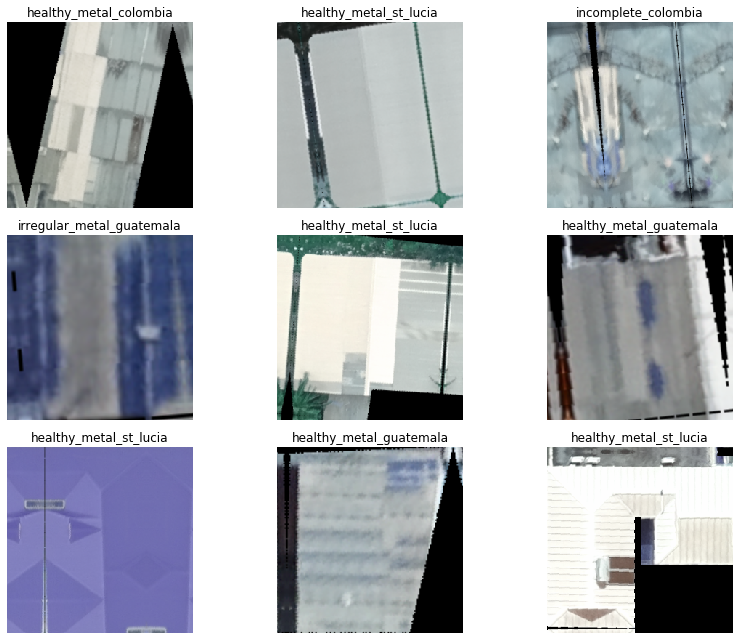

In [33]:
data.show_batch(rows=3, figsize=(12,9))

### Model

In [34]:
#exp1 = IPyExperimentsPytorch()

In [35]:
arch = models.resnet50
arch_name = 'rn50'

In [36]:
#acc_02 = partial(accuracy_thresh, thresh=0.2)
#f_score = partial(fbeta, thresh=0.2)

In [37]:
learn = cnn_learner(data, arch, metrics=error_rate, bn_final=True).to_fp16()

In [38]:
#learn.model = torch.nn.DataParallel(learn.model, device_ids=[0, 1, 2])

We use the LR Finder to pick a good learning rate.

### Train model

In [39]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


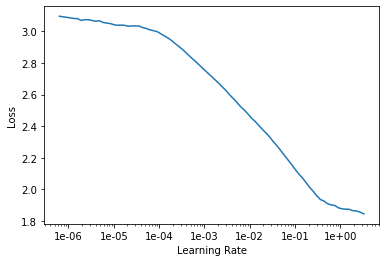

In [40]:
learn.recorder.plot()

Then we can fit the head of our network.

In [41]:
lr = 1e-2

In [42]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,1.217019,0.708485,0.195565,01:11
1,0.618382,0.452808,0.156098,01:16
2,0.481027,0.415937,0.145011,01:14
3,0.429614,0.399151,0.141907,01:11
4,0.411088,0.397632,0.143237,01:19


In [43]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [44]:
learn.save(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')


In [45]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.413748,0.417352,0.144568,00:57
1,0.425194,0.410373,0.142350,01:04
2,0.404489,0.387200,0.134368,01:02
3,0.376647,0.380524,0.127273,01:05
4,0.352455,0.375377,0.129490,01:05


In [53]:
learn.save(f'stage-1-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

#### Load model

In [55]:
learn.load(f'stage-1-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (18043 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
concrete_cement;colombia,irregular_metal;colombia,healthy_metal;colombia,healthy_metal;colombia,healthy_metal;colombia
Path: data/train/rotated/clipped/256;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
irregular_metal;guatemala,healthy_metal;st_lucia,healthy_metal;colombia,irregular_metal;colombia,healthy_metal;st_lucia
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(i

In [56]:
#interp = ClassificationInterpretation.from_learner(learn)
#interp.most_confused(min_val=2)

In [57]:
#interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

In [ ]:
cpu_data = exp1.data.cpu
gpu_data = exp1.data.gpu
print(cpu_data, gpu_data)

In [ ]:
del exp1

### Re-train

In [ ]:
exp2 = IPyExperimentsPytorch()

In [58]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


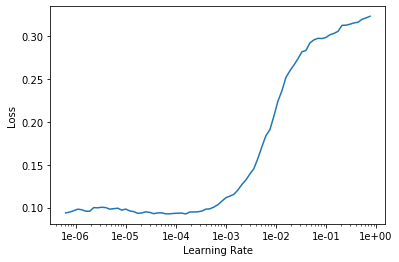

In [59]:
learn.lr_find()
learn.recorder.plot()

In [60]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.112966,0.123142,0.938609,0.924749,01:40
1,0.119734,0.114103,0.941436,0.930726,01:40
2,0.110200,0.116567,0.948586,0.938692,01:44
3,0.096927,0.090432,0.953548,0.945607,01:46
4,0.091319,0.089104,0.954656,0.946715,01:48


<pre>
epoch 	train_loss 	valid_loss 	error_rate 	time
0 	0.438103 	0.431031 	0.157428 	01:37
1 	0.413694 	0.500094 	0.179823 	01:38
2 	0.405334 	0.394548 	0.143902 	01:35
3 	0.400567 	0.368481 	0.135920 	01:35
4 	0.352880 	0.357799 	0.128381 	01:35
    </pre>

In [62]:
learn.save(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [63]:
learn.load(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (18043 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
concrete_cement;colombia,irregular_metal;colombia,healthy_metal;colombia,healthy_metal;colombia,healthy_metal;colombia
Path: data/train/rotated/clipped/256;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
irregular_metal;guatemala,healthy_metal;st_lucia,healthy_metal;colombia,irregular_metal;colombia,healthy_metal;st_lucia
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(i

In [64]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.101494,0.115161,0.947062,0.934734,01:39
1,0.107429,0.108522,0.948198,0.941349,01:41
2,0.103956,0.096601,0.951053,0.941742,01:50
3,0.089361,0.088106,0.956486,0.947879,01:49
4,0.081973,0.086087,0.956236,0.949511,01:50


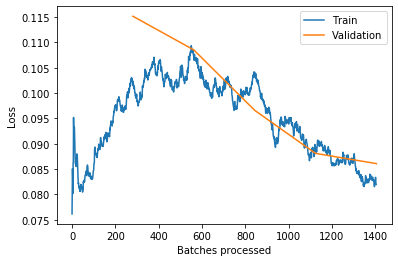

In [65]:
learn.recorder.plot_losses()

In [ ]:
cpu_data = exp2.data.cpu
gpu_data = exp2.data.gpu
print(cpu_data, gpu_data)

In [66]:
learn.save(f'stage-2-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [68]:
learn = learn.to_fp32()

In [69]:
learn.export(f'stage-2-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.pkl')

In [70]:
learn.export()

In [ ]:
del exp2

### inference

In [90]:
#test_images=data_dir/f'test/rotated/clipped/{img_size}'
test_dataset=ImageList.from_folder(test_images)

In [91]:
len(test_dataset)

15325

In [92]:
learn = load_learner(path=data_dir/f'train/rotated/clipped/{img_size}', test=test_dataset)

In [93]:
learn.data.loss_func

FlattenedLoss of BCEWithLogitsLoss()

In [94]:
type(learn.data)

fastai.vision.data.ImageDataBunch

In [95]:
type(learn.dl(DatasetType.Test))

fastai.basic_data.DeviceDataLoader

In [96]:
len(learn.dl(DatasetType.Test))

240

In [97]:
preds,y= learn.get_preds(ds_type=DatasetType.Test)

In [98]:
learn.data.c

8

In [99]:
learn.data.classes

['colombia',
 'concrete_cement',
 'guatemala',
 'healthy_metal',
 'incomplete',
 'irregular_metal',
 'other',
 'st_lucia']

In [100]:
preds.shape

torch.Size([15325, 8])

We dont want the countries

In [101]:
colombia_preds = preds[:,0]
guatemala_preds = preds[:,2]
st_lucia_preds = preds[:,7]

In [102]:
roof_indexes=[1,3,4,5,6]

In [103]:
roof_classes = np.array(learn.data.classes)
roof_classes=roof_classes[roof_indexes]

In [104]:
roof_preds = preds[:, roof_indexes]

In [105]:
labels = np.argmax(roof_preds, 1)

In [106]:
len(roof_preds)

15325

In [107]:
preds_list=[]
for pred in roof_preds:
    preds_list.append(pred.tolist())

In [108]:
test_predictions = [roof_classes[int(x)] for x in labels]

In [109]:
test_predictions[0]

'healthy_metal'

In [110]:
ids=[]
for item in learn.data.test_ds.x.items:
    base, id = os.path.split(item)
    id = id.split('.tif')[0]
    ids.append(id)

In [111]:
preds_list[0]

[0.06928220391273499,
 0.9192302227020264,
 0.002284455578774214,
 0.017573129385709763,
 0.004868258256465197]

In [113]:
cols = list(roof_classes.copy())
cols.insert(0,'id')
df = pd.DataFrame(list(zip(ids, preds_list)), 
               columns =['id', 'pred']) 

In [114]:
cols

['id',
 'concrete_cement',
 'healthy_metal',
 'incomplete',
 'irregular_metal',
 'other']

In [115]:
df.head()

,id,pred
0,7a4d9168,"[0.06928220391273499, 0.9192302227020264, 0.00..."
1,7a4ae922,"[0.007171390112489462, 0.8835989236831665, 0.0..."
2,7a48ca98,"[0.003951289225369692, 0.1605711281299591, 0.0..."
3,7a49c614,"[0.0016889681573957205, 0.7612203359603882, 0...."
4,7a4dd4f2,"[0.000488712394144386, 0.9064734578132629, 0.0..."


In [116]:
pred_df = pd.DataFrame(df['pred'].values.tolist())

In [117]:
pred_df.insert(loc=0, column='id', value=ids)

In [118]:
pred_df.columns = cols

In [119]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d9168,0.069282,0.919230,0.002284,0.017573,0.004868
1,7a4ae922,0.007171,0.883599,0.004296,0.124153,0.001806
2,7a48ca98,0.003951,0.160571,0.013753,0.813957,0.001167
3,7a49c614,0.001689,0.761220,0.001681,0.285033,0.000649
4,7a4dd4f2,0.000489,0.906473,0.000866,0.076578,0.003934


Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>


#### Format correctly

In [120]:
pred_ids=pred_df['id'].values.tolist()

In [121]:
df_baseline = pd.read_csv(data_dir/f'submissions/mean_baseline.csv')

In [122]:
df_baseline.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d630a,0.093275,0.496369,0.044923,0.352455,0.012979
1,7a4bbbd6,0.093275,0.496369,0.044923,0.352455,0.012979
2,7a4ac744,0.093275,0.496369,0.044923,0.352455,0.012979
3,7a4881fa,0.093275,0.496369,0.044923,0.352455,0.012979
4,7a4aa4a8,0.093275,0.496369,0.044923,0.352455,0.012979


In [123]:
baseline_ids=df_baseline['id'].values.tolist()

In [124]:
assert set(pred_ids)==set(baseline_ids)

#### sort by baseline ids

In [125]:
pred_df['id_cat'] = pd.Categorical(
    pred_df['id'], 
    categories=baseline_ids, 
    ordered=True
)

In [126]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,id_cat
0,7a4d9168,0.069282,0.919230,0.002284,0.017573,0.004868,7a4d9168
1,7a4ae922,0.007171,0.883599,0.004296,0.124153,0.001806,7a4ae922
2,7a48ca98,0.003951,0.160571,0.013753,0.813957,0.001167,7a48ca98
3,7a49c614,0.001689,0.761220,0.001681,0.285033,0.000649,7a49c614
4,7a4dd4f2,0.000489,0.906473,0.000866,0.076578,0.003934,7a4dd4f2


In [127]:
pred_df=pred_df.sort_values('id_cat')

In [128]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,id_cat
8041,7a4d630a,0.005879,0.988965,0.002195,0.005204,0.001443,7a4d630a
716,7a4d630a,0.005879,0.988965,0.002195,0.005204,0.001443,7a4d630a
764,7a4bbbd6,0.003444,0.979866,0.000987,0.018707,0.000464,7a4bbbd6
8089,7a4bbbd6,0.003444,0.979866,0.000987,0.018707,0.000464,7a4bbbd6
1841,7a4ac744,0.012868,0.729675,0.010412,0.254341,0.001905,7a4ac744


In [129]:
pred_df.drop(columns=['id_cat'],inplace=True)

In [16]:
arch_name='rn50'

In [19]:
pred_df=pd.read_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv')

In [20]:
pred_df=pred_df.drop_duplicates(subset=['id'])

In [21]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d630a,0.005879,0.988965,0.002195,0.005204,0.001443
2,7a4bbbd6,0.003444,0.979866,0.000987,0.018707,0.000464
4,7a4ac744,0.012868,0.729675,0.010412,0.254341,0.001905
6,7a4881fa,0.010423,0.121171,0.011538,0.868380,0.001099
8,7a4aa4a8,0.003680,0.703557,0.004458,0.307858,0.001585


In [22]:
pred_df.to_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv', index=False)

In [1]:
### Submission 2: 0.4461


In [16]:
arch_name = 'rn50'
pred_df=pd.read_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv')

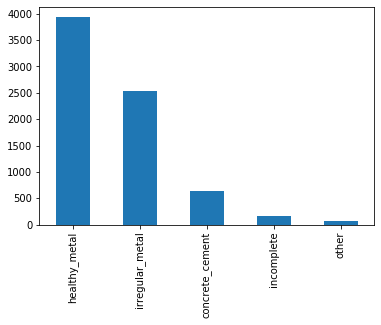

In [17]:
pred_df.drop(columns=['id'],inplace=True)
classes=pred_df.idxmax(axis=1)
pd.value_counts(classes).plot(kind="bar")